In [672]:
from torch import nn
from torch.ao.nn.quantized import Dropout
import torch.nn.functional as F
import wandb
import torch

import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Normalization

In [673]:
#load data

path = '../dataset'
energy_interval = 'use'

augmented = False

if augmented:
	x_train = np.load(f'{path}/x_train_augmented_{energy_interval}.npy')
	y_train = np.load(f'{path}/y_train_augmented_{energy_interval}.npy')
else:
	x_train = np.load(f'{path}/x_train_{energy_interval}.npy')
	y_train = np.load(f'{path}/y_train_{energy_interval}.npy')
x_test = np.load(f'{path}/x_test_{energy_interval}.npy')
y_test = np.load(f'{path}/y_test_{energy_interval}.npy')


In [678]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((70222, 1734), (70222, 8), (5626, 1734), (5626, 8))

In [679]:
y_train_avg = np.dot(y_train, np.arange(8))
y_test_avg = np.dot(y_test, np.arange(8))

In [680]:
y_train_avg = y_train_avg.reshape(-1, 1)
y_test_avg = y_test_avg.reshape(-1, 1)

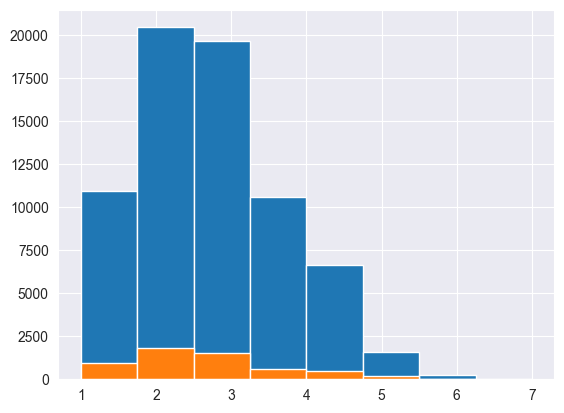

In [681]:
#histogram of average oxidation states
import matplotlib.pyplot as plt
plt.hist(y_train_avg, bins=8)
plt.hist(y_test_avg, bins=8)
plt.show()

In [682]:
np.save(f'y_test_avg.npy', y_test_avg)
np.save(f'y_train_avg.npy', y_train_avg)
np.save(f'x_train.npy', x_train)
np.save(f'x_test.npy', x_test)

## Hyperparameter Tuning

In [683]:
learning_rate = 0.01
batch_size = 256
num_epochs = 75

## Model Training

### Model Definitions

In [684]:
import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.1):
        super(SimpleNN, self).__init__()

        self.fc1 = nn.Linear(input_size, int(input_size / 2))
        self.bn1 = nn.BatchNorm1d(int(input_size / 2))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(int(input_size / 2), int(input_size / 2))
        self.bn2 = nn.BatchNorm1d(int(input_size / 2))

        self.fc3 = nn.Linear(int(input_size / 2), int(input_size / 4))
        self.bn3 = nn.BatchNorm1d(int(input_size / 4))

        self.fc4 = nn.Linear(int(input_size / 4), 128)
        self.bn4 = nn.BatchNorm1d(128)

        self.fc5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(16, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc4(out)
        out = self.bn4(out)
        out = self.relu(out)

        out = self.fc5(out)
        out = self.bn5(out)
        out = self.relu(out)

        out = self.fc6(out)
        out = self.relu(out)
        out = self.fc7(out)
        out = self.relu(out)
        out = self.fc8(out)

        return torch.softmax(out, dim = 1)

In [685]:
# Make data loaders

from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [686]:
def weighted_mse_loss(pred, target):
    """
    Custom weighted MSE loss where weights are the indices of the vector.
    Args:
        pred (Tensor): Predicted vector, shape (batch_size, n).
        target (Tensor): Ground truth vector, shape (batch_size, n).
    Returns:
        loss (Tensor): Weighted average loss.
    """
    # Create weights as the index of each element (1-based)
    weights = torch.arange(0, pred.size(1), device=pred.device).float()  # Shape: (n,)

    # Compute the element-wise squared error
    error = (pred - target) ** 2  # Shape: (batch_size, n)

    # Apply weights
    weighted_error = weights * error  # Shape: (batch_size, n)

    # Average over all elements and samples
    loss = weighted_error.mean()
    return loss

### Training Loop

In [687]:
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler

def train_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, architecture):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Learning Rate Scheduler (ReduceLR when validation loss plateaus)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]")

        for images, labels in train_loader_tqdm:
            images = images.to(device)
            labels = labels.to(device)
            if architecture == 'CNN':
                images = images.unsqueeze(1)

            # Forward pass
            outputs = model(images)
            loss = weighted_mse_loss(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_loader_tqdm.set_postfix(loss=loss.item())  # Update progress bar with current loss

        # Calculate average training loss
        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]")

        with torch.no_grad():
            for images, labels in test_loader_tqdm:
                images = images.to(device)
                labels = labels.to(device)
                if architecture == 'CNN':
                    images = images.unsqueeze(1)

                # Forward pass
                outputs = model(images)
                loss = weighted_mse_loss(outputs, labels)

                val_loss += loss.item()
                test_loader_tqdm.set_postfix(loss=loss.item())  # Update progress bar with current loss

        val_loss /= len(test_loader)  # Average validation loss

        # Step the scheduler based on validation loss

        # Print epoch summary

    return model


In [ ]:
input_size = x_train.shape[1]
num_classes = y_train.shape[1]
lr = learning_rate
training_size = len(train_loader)
testing_size = len(test_loader)
# model = CNN1D(num_classes).to(device)
model = SimpleNN(input_size, num_classes).to(device)
# model = SimpleRNN(num_classes=num_classes).to(device)
batch_size = batch_size
num_epochs = num_epochs
architecture = 'FNN' if isinstance(model, SimpleNN) else 'CNN'
# architecture = 'FNN' if isinstance(model, SimpleNN) else 'RNN'

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model = train_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, architecture)


Epoch 14/75 [Training]:  96%|█████████▌| 263/275 [00:04<00:00, 51.55it/s, loss=0.00693]

## Performance Analysis

In [ ]:
#predict average oxidation state

def predict_avg_oxi_state(model, x):

	x = torch.Tensor(x).to(device)
	output = model(x).detach()
	return output.numpy()

output = predict_avg_oxi_state(model, x_test)


In [ ]:
# print(output.numpy(), y_test)
oxi_states = np.array(list(range(0,8)))
avg_oxi_state = np.dot(y_test, oxi_states)
avg_oxi_state_predicted = np.dot(output, oxi_states)

In [ ]:
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error
import matplotlib.pyplot as plt
# confusion_matrix(avg_oxi_state, avg_oxi_state_predicted)
plt.plot(avg_oxi_state, avg_oxi_state_predicted, 'o')
# plt.plot(y_test_avg, output, 'o')
plt.show()

print("R2_score: ", round(r2_score(avg_oxi_state, avg_oxi_state_predicted),2))
print("MSE: ", round(mean_squared_error(avg_oxi_state, avg_oxi_state_predicted),2))
# print(r2_score(y_test_avg, output))

In [ ]:
# np.save(f'y_test_used.npy', y_test)
# np.save(f'output_fnn.npy', output.numpy())